In [1]:
import scanpy as sc
import anndata as ann
import scipy as sci
import pandas as pd
import os
import numpy as np
import seaborn as sns
import episcanpy.api as epi

/home/97212545/anaconda3/envs/scanpy/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
DATA_DIR = '../data/10xpbmc10k-2020/'

# Load the Data

In [6]:
scdata = sc.read_10x_h5(DATA_DIR + 'pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5', gex_only=False)
scdata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 11909 × 144978
    var: 'gene_ids', 'feature_types', 'genome'

In [7]:
scrna = scdata[:, scdata.var['feature_types'] == 'Gene Expression']
scatac = scdata[:, scdata.var['feature_types'] == 'Peaks']
scrna, scatac

(View of AnnData object with n_obs × n_vars = 11909 × 36601
     var: 'gene_ids', 'feature_types', 'genome',
 View of AnnData object with n_obs × n_vars = 11909 × 108377
     var: 'gene_ids', 'feature_types', 'genome')

# scRNA-seq Data

In [8]:
scrna.obs.head()

""
AAACAGCCAAGGAATC-1
AAACAGCCAATCCCTT-1
AAACAGCCAATGCGCT-1
AAACAGCCACACTAAT-1
AAACAGCCACCAACCG-1


In [9]:
scrna.var.head()

,gene_ids,feature_types,genome
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38
FAM138A,ENSG00000237613,Gene Expression,GRCh38
OR4F5,ENSG00000186092,Gene Expression,GRCh38
AL627309.1,ENSG00000238009,Gene Expression,GRCh38
AL627309.3,ENSG00000239945,Gene Expression,GRCh38


## Data Cleaning

In [10]:
scrna_clusters = pd.read_csv(DATA_DIR + 'analysis/clustering/gex/graphclust/clusters.csv', index_col=0)
scrna_clusters = scrna_clusters.astype('category')
scrna_clusters = scrna_clusters.rename(columns={'Cluster': 'cell_type'})
scrna_clusters.head()

,cell_type
Barcode,
AAACAGCCAAGGAATC-1,2
AAACAGCCAATCCCTT-1,8
AAACAGCCAATGCGCT-1,2
AAACAGCCACACTAAT-1,9
AAACAGCCACCAACCG-1,4


In [11]:
scrna.obs = scrna.obs.join(scrna_clusters, how='left', sort=False)
scrna.obs.head()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


,cell_type
AAACAGCCAAGGAATC-1,2
AAACAGCCAATCCCTT-1,8
AAACAGCCAATGCGCT-1,2
AAACAGCCACACTAAT-1,9
AAACAGCCACCAACCG-1,4


# Quality Control

In [15]:
scrna.var_names_make_unique()

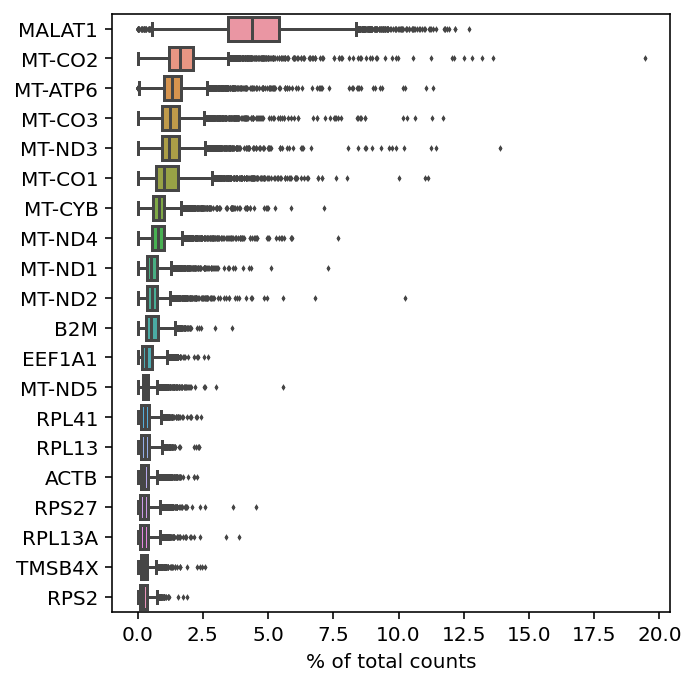

In [16]:
sc.pl.highest_expr_genes(scrna, n_top=20)

In [17]:
sc.pp.filter_cells(scrna, min_genes=100)
sc.pp.filter_genes(scrna, min_cells=3)
scrna

AnnData object with n_obs × n_vars = 11903 × 26349
    obs: 'cell_type', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

## Qalculate QC metrics including Mitochondrial genes

In [18]:
scrna.var['mt'] = scrna.var.index.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(scrna, qc_vars=['mt'], percent_top=None, inplace=True)
scrna

AnnData object with n_obs × n_vars = 11903 × 26349
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

... storing 'feature_types' as categorical
... storing 'genome' as categorical


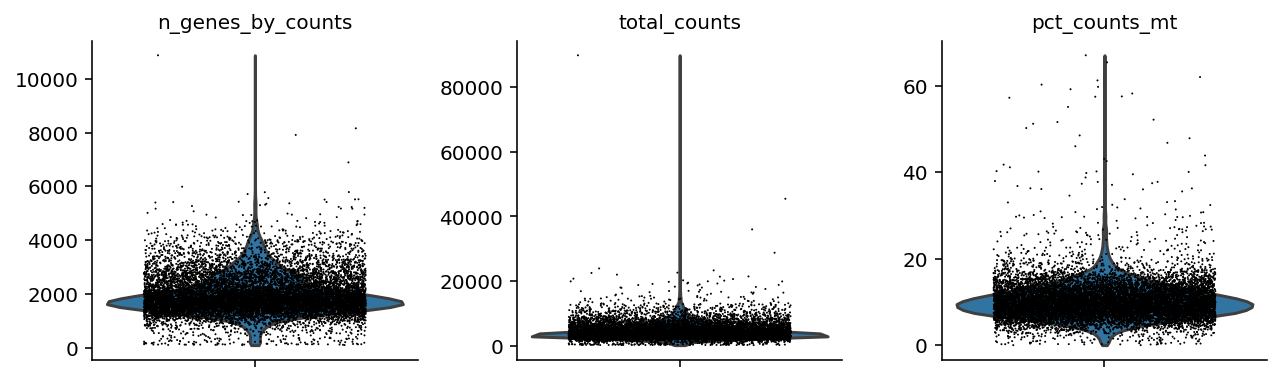

In [19]:
sc.pl.violin(scrna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.3, multi_panel=True)

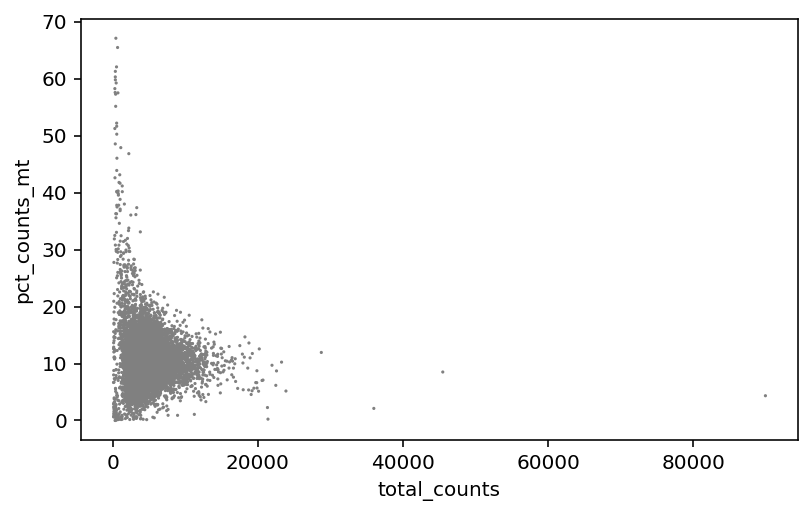

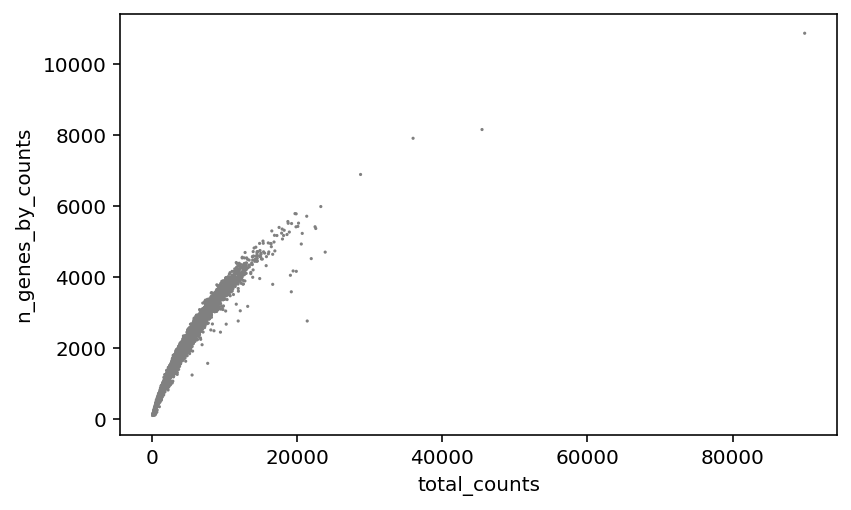

In [20]:
sc.pl.scatter(scrna, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(scrna, x='total_counts', y='n_genes_by_counts')

Filter out high mitochondrial samples and samples with highest number of genes:

In [21]:
scrna = scrna[scrna.obs.n_genes_by_counts < 5000, :]
scrna = scrna[scrna.obs.pct_counts_mt < 30, :]
scrna

View of AnnData object with n_obs × n_vars = 11810 × 26349
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## Normalization

In [22]:
sc.pp.normalize_total(scrna, target_sum=1e4)
sc.pp.log1p(scrna)

## Filtering Highly Variable Genes

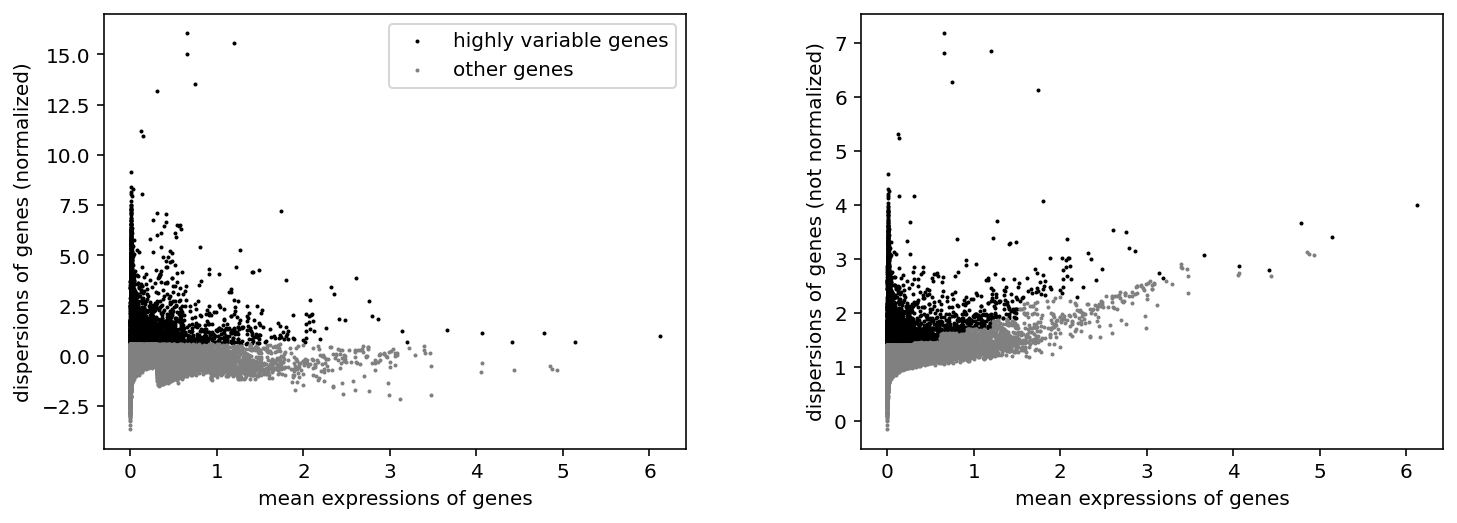

In [23]:
sc.pp.highly_variable_genes(scrna, n_top_genes=4000)
sc.pl.highly_variable_genes(scrna)

In [24]:
scrna = scrna[:, scrna.var.highly_variable]
scrna

View of AnnData object with n_obs × n_vars = 11810 × 4000
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

## Visualization

### Running UMAP

In [25]:
sc.pp.neighbors(scrna)
sc.tl.umap(scrna)

         Falling back to preprocessing with `sc.pp.pca` and default params.


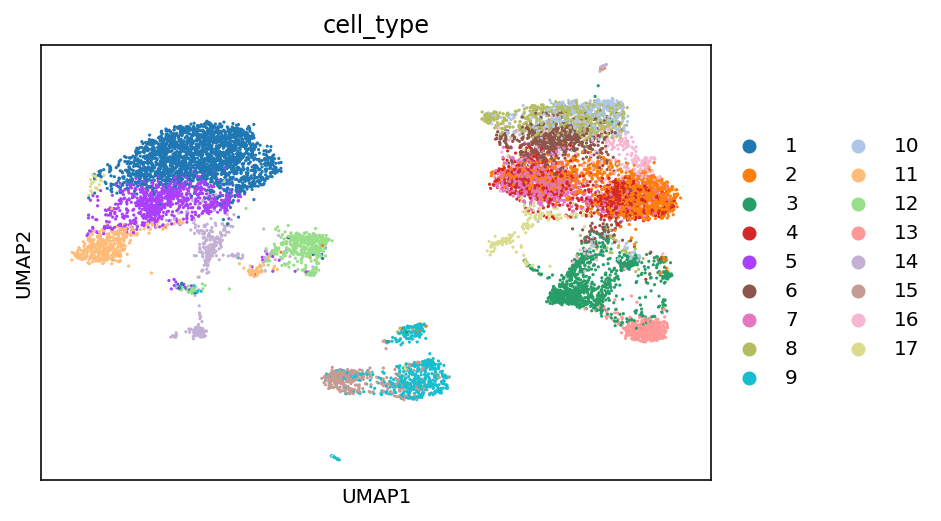

In [26]:
sc.pl.umap(scrna, color=['cell_type'])

---
# scATAC-seq Data

In [27]:
scatac.obs

""
AAACAGCCAAGGAATC-1
AAACAGCCAATCCCTT-1
AAACAGCCAATGCGCT-1
AAACAGCCACACTAAT-1
AAACAGCCACCAACCG-1
...
TTTGTTGGTGTTAAAC-1
TTTGTTGGTTAGGATT-1
TTTGTTGGTTGCAGTA-1
TTTGTTGGTTGGTTAG-1


In [28]:
scatac.var.head()

,gene_ids,feature_types,genome
chr1:10109-10357,chr1:10109-10357,Peaks,GRCh38
chr1:180730-181630,chr1:180730-181630,Peaks,GRCh38
chr1:191491-191736,chr1:191491-191736,Peaks,GRCh38
chr1:267816-268196,chr1:267816-268196,Peaks,GRCh38
chr1:586028-586373,chr1:586028-586373,Peaks,GRCh38


## Data Cleaning

In [29]:
scatac_clusters = pd.read_csv(DATA_DIR + 'analysis/clustering/atac/graphclust/clusters.csv', index_col=0)
scatac_clusters = scatac_clusters.astype('category')
scatac_clusters = scatac_clusters.rename(columns={'Cluster': 'cell_type'})
scatac_clusters.head()

,cell_type
Barcode,
AAACAGCCAAGGAATC-1,6
AAACAGCCAATCCCTT-1,15
AAACAGCCAATGCGCT-1,6
AAACAGCCACACTAAT-1,1
AAACAGCCACCAACCG-1,1


In [30]:
scatac.obs = scatac.obs.join(scatac_clusters, how='left', sort=False)
scatac.obs.head()

,cell_type
AAACAGCCAAGGAATC-1,6
AAACAGCCAATCCCTT-1,15
AAACAGCCAATGCGCT-1,6
AAACAGCCACACTAAT-1,1
AAACAGCCACCAACCG-1,1


We do not want clusters 18 and 19 since they are not available in GEX:

In [36]:
scatac = scatac[~scatac.obs['cell_type'].isin([18, 19])]
scatac

View of AnnData object with n_obs × n_vars = 11474 × 108377
    obs: 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome'

## Quality Control

### Basic filtering

In [37]:
epi.pp.filter_features(scatac, min_cells=1)
epi.pp.filter_cells(scatac, min_features=1)
scatac

Trying to set attribute `.var` of view, copying.


AnnData object with n_obs × n_vars = 11474 × 107839
    obs: 'cell_type', 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

## Binarization

In [38]:
%time epi.pp.binarize(scatac)
scatac

CPU times: user 6.71 s, sys: 6.75 s, total: 13.5 s
Wall time: 13.6 s


AnnData object with n_obs × n_vars = 11474 × 107839
    obs: 'cell_type', 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

## Filter low quality cells and peaks

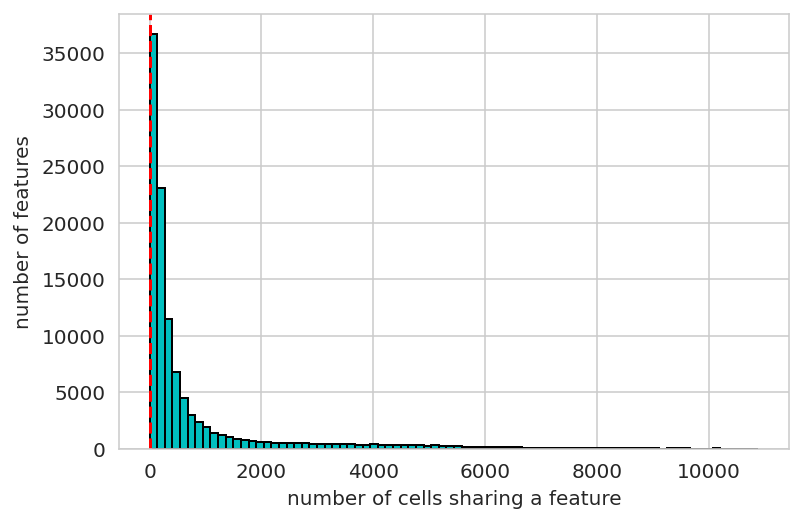

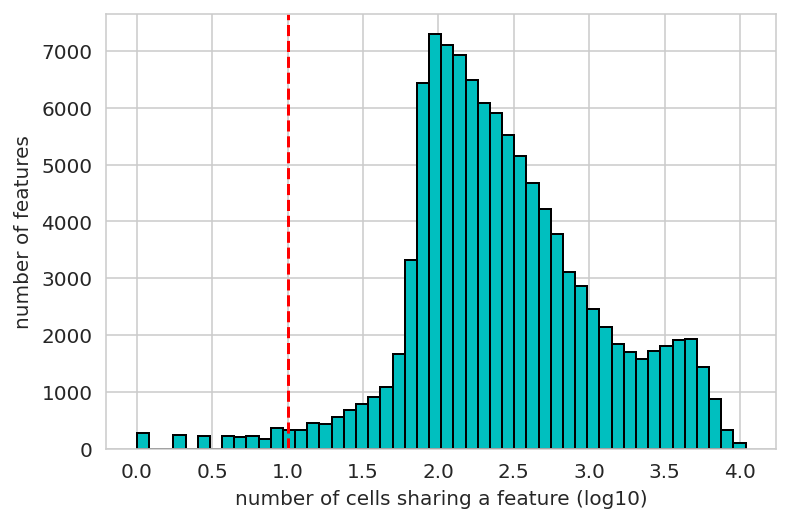

In [41]:
epi.pp.coverage_features(scatac, binary=True, log=False, bins=50, threshold=10)
epi.pp.coverage_features(scatac, binary=True, log=10, bins=50, threshold=10)

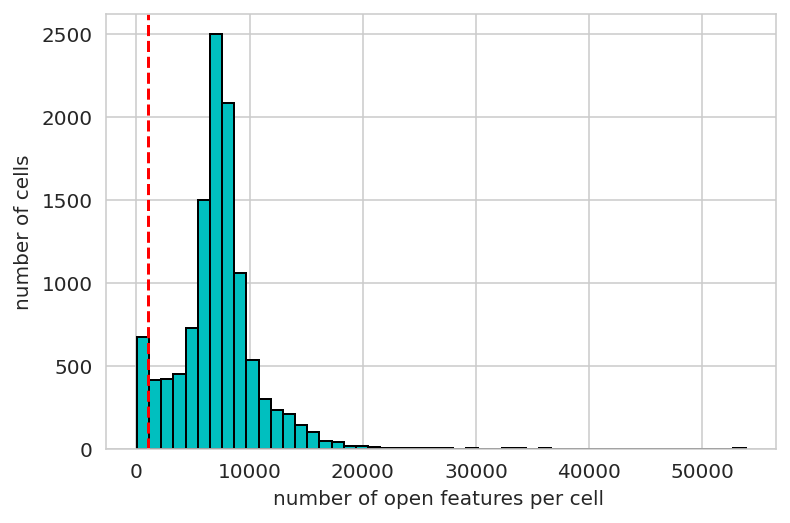

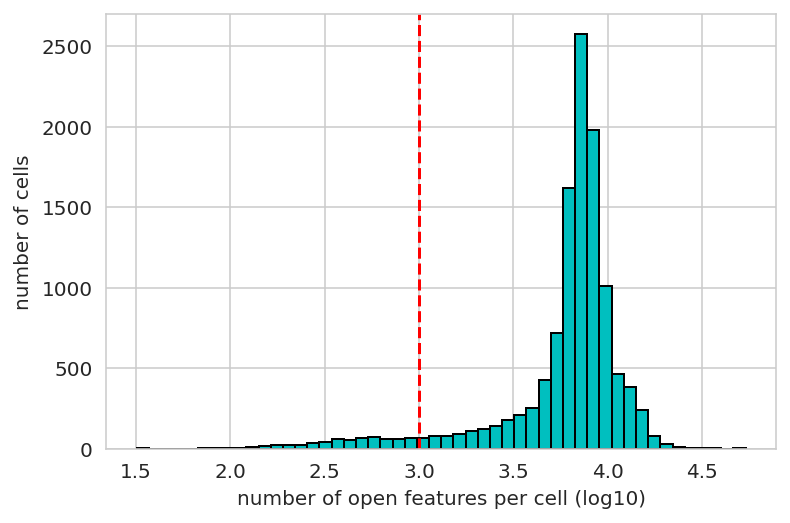

In [42]:
epi.pp.coverage_cells(scatac, binary=True, log=False, bins=50, threshold=1000)
epi.pp.coverage_cells(scatac, binary=True, log=10, bins=50, threshold=1000)

In [43]:
epi.pp.filter_cells(scatac, min_features=1000)
epi.pp.filter_features(scatac, min_cells=10)
scatac

AnnData object with n_obs × n_vars = 10848 × 105922
    obs: 'cell_type', 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness'

Filtering cells with high open peaks and peaks with high number of cells:

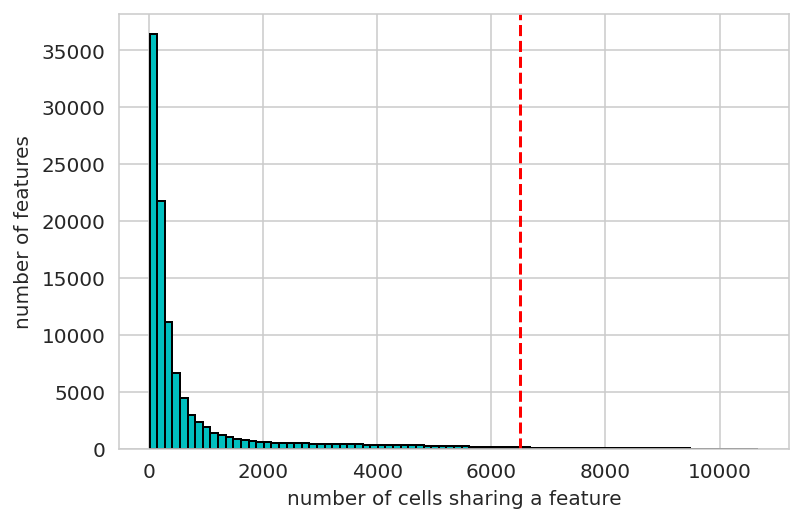

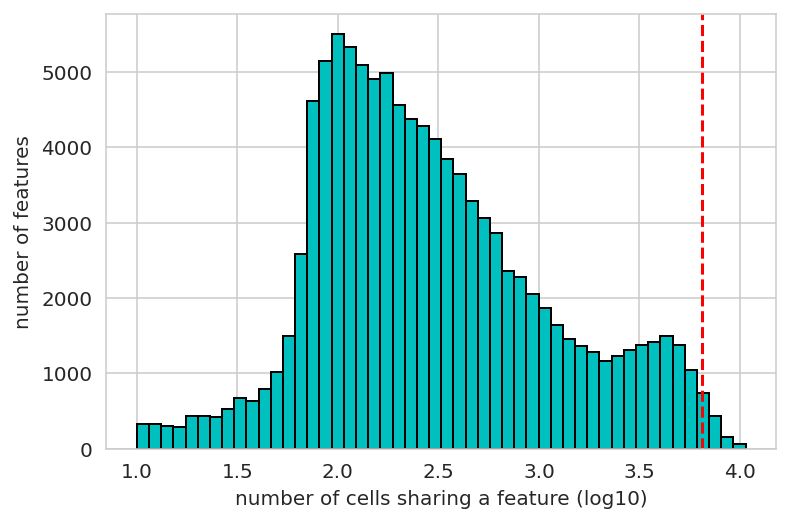

In [46]:
epi.pp.coverage_features(scatac, binary=True, log=False, bins=50, threshold=6500)
epi.pp.coverage_features(scatac, binary=True, log=True, bins=50, threshold=6500)

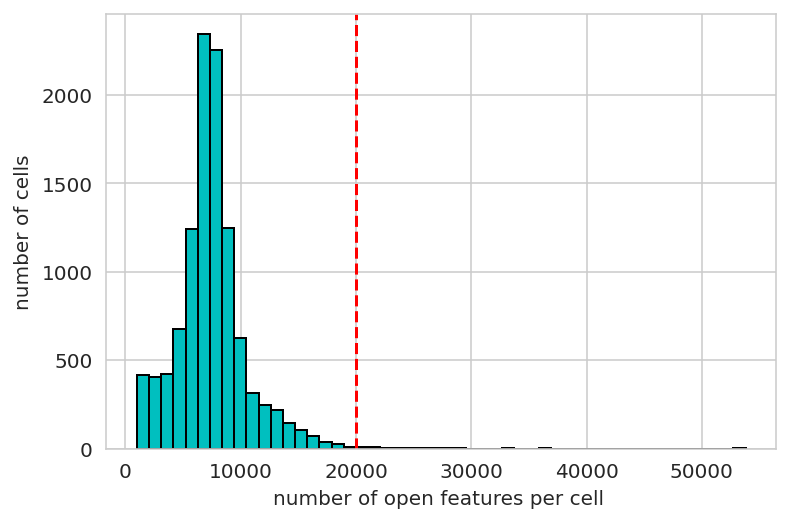

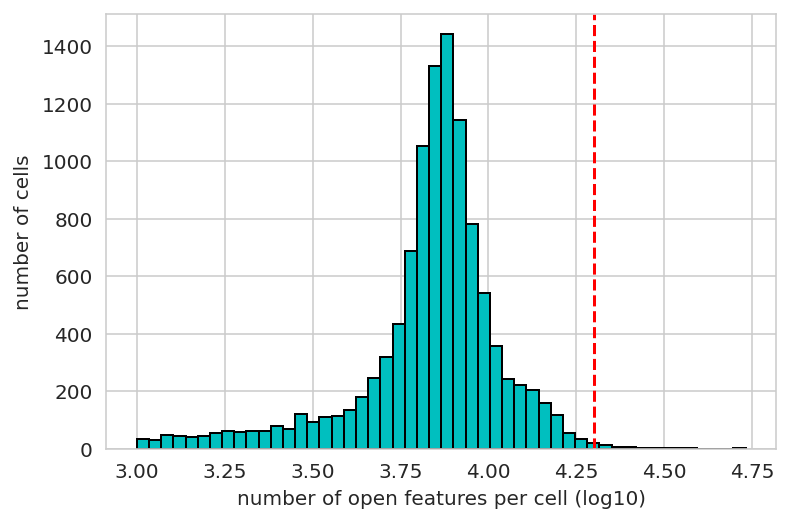

In [47]:
epi.pp.coverage_cells(scatac, binary=True, log=False, bins=50, threshold=20000)
epi.pp.coverage_cells(scatac, binary=True, log=True, bins=50, threshold=20000)

In [48]:
epi.pp.filter_cells(scatac, max_features=20000)
epi.pp.filter_features(scatac, max_cells=6500)
scatac

AnnData object with n_obs × n_vars = 10810 × 104943
    obs: 'cell_type', 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness'

In [49]:
scatac.obs['nb_features'].describe()

count    10810.000000
mean      7412.900000
std       2887.069414
min       1001.000000
25%       5987.000000
50%       7300.000000
75%       8618.500000
max      19967.000000
Name: nb_features, dtype: float64

In [50]:
scatac.var['commonness'].describe()

count    104943.000000
mean        701.787227
std        1170.145073
min          10.000000
25%         110.000000
50%         230.000000
75%         620.000000
max        6537.000000
Name: commonness, dtype: float64

In [51]:
scatac.var['commonness'].median()

230.0

In [52]:
scatac = scatac[:, scatac.var['commonness'] > scatac.var['commonness'].median()]
scatac

View of AnnData object with n_obs × n_vars = 10810 × 52422
    obs: 'cell_type', 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness'

## Selecting variable peaks

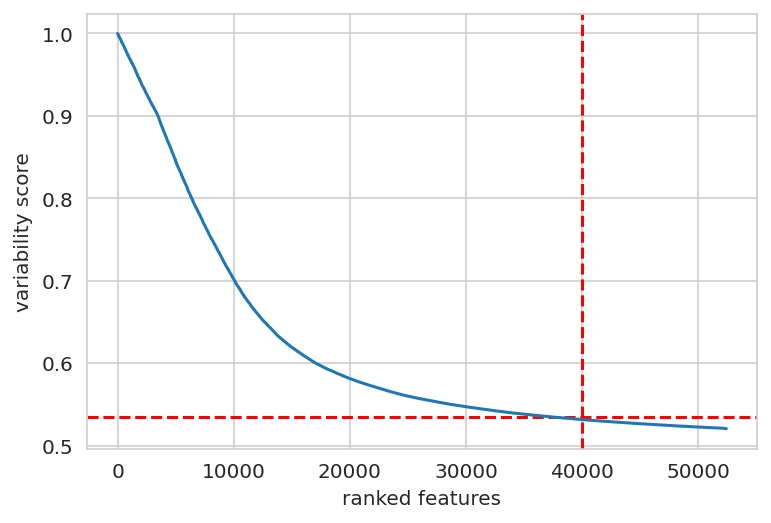

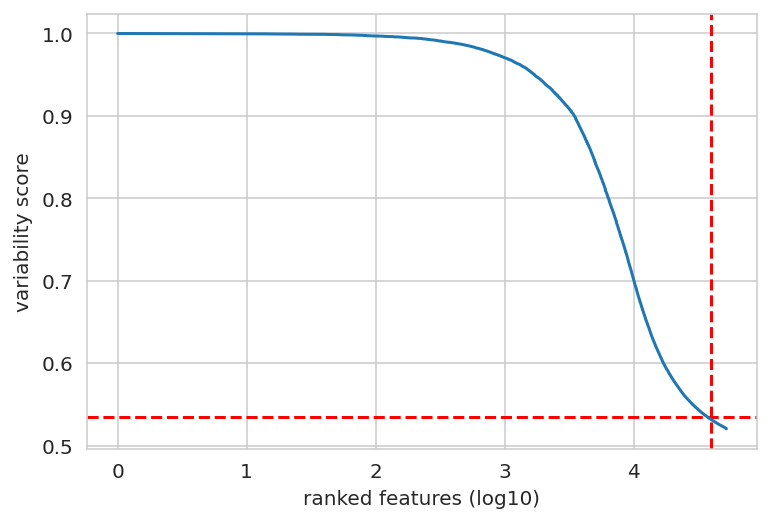

In [54]:
min_score_value = 0.535
nb_feature_selected = 40000
epi.pl.variability_features(scatac, log=None, min_score=min_score_value, nb_features=nb_feature_selected)
epi.pl.variability_features(scatac, log='log10', min_score=min_score_value, nb_features=nb_feature_selected)

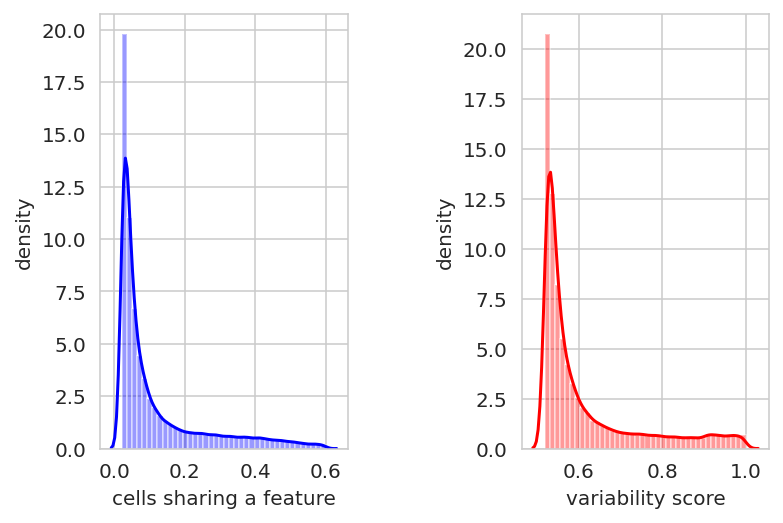

CPU times: user 2.46 s, sys: 10.5 s, total: 12.9 s
Wall time: 13.6 s


In [55]:
%time epi.pp.select_var_feature(scatac, nb_features=nb_feature_selected)

In [56]:
scatac

AnnData object with n_obs × n_vars = 10810 × 40007
    obs: 'cell_type', 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

## Normalization

In [57]:
epi.pp.normalize_total(scatac, target_sum=1e4)
epi.pp.log1p(scatac)

## Visualization

### Running UMAP

In [58]:
sc.pp.neighbors(scatac)
sc.tl.umap(scatac)

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'feature_types' as categorical
... storing 'genome' as categorical


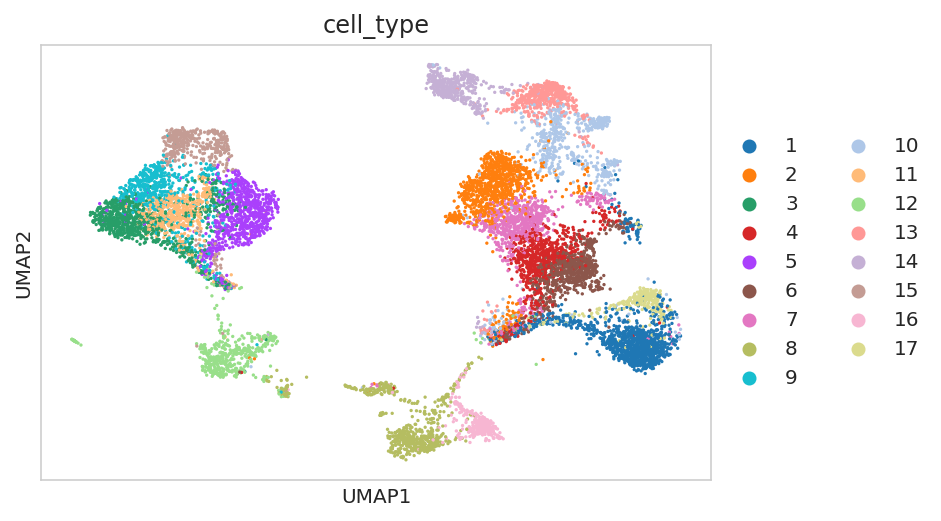

In [59]:
sc.pl.umap(scatac, color=['cell_type'])

---
# Save the results

### Find common paired samples

In [60]:
com_index = set(scrna.obs.index) & set(scatac.obs.index)
scrna = scrna[scrna.obs.index.isin(com_index)]
scatac = scatac[scatac.obs.index.isin(com_index)]
print(scrna.shape, scatac.shape)

(10736, 4000) (10736, 40007)


In [61]:
%time scrna.write(DATA_DIR + 'expressions.h5ad')

CPU times: user 188 ms, sys: 56 ms, total: 244 ms
Wall time: 406 ms


In [62]:
%time scatac.write_h5ad(DATA_DIR + 'peaks.h5ad')

CPU times: user 968 ms, sys: 18.4 s, total: 19.3 s
Wall time: 19.3 s
